In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict

In [2]:
#Checking GPU is avaibale or not
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
# Loading dataset from CSV file
from datasets import load_dataset, DatasetDict
train_data = load_dataset('csv', data_files='3_split_data/train.csv')
test_data = load_dataset('csv', data_files='3_split_data/test.csv')
validation_data = load_dataset('csv', data_files='3_split_data/validation.csv')
dataset = DatasetDict({
    'train': train_data['train'],
    'test': test_data['train'],
    'validation':validation_data['train']
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 9856
    })
    test: Dataset({
        features: ['content', 'label'],
        num_rows: 2113
    })
    validation: Dataset({
        features: ['content', 'label'],
        num_rows: 2112
    })
})


In [4]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="distilbert/distilbert-base-multilingual-cased")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [5]:
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")


In [6]:
def tokenize_function(examples):
    contents = [str(content) for content in examples['content']]
    return tokenizer(contents, padding="max_length", truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9856
    })
    test: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2113
    })
    validation: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2112
    })
})


In [7]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', num_labels=12)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.optim import AdamW

# Define compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training Parameters
batch_size = 10
no_epochs = 4
train_len = len(dataset['train'])
steps = (train_len * no_epochs) / batch_size

training_args = TrainingArguments(
    eval_strategy="epoch",  # Evaluation at the end of each epoch
    logging_strategy="steps",
    save_strategy="epoch",  # Save at the end of each epoch
    output_dir='./nepali_news_distillbert_fine_tuned_model',  # Save the model here
    logging_dir='./logs',  # Directory to store logs
    logging_steps=train_len // batch_size,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=no_epochs,
    weight_decay=0.05,
    learning_rate=3e-5,
    warmup_steps=int(0.05 * steps),
    load_best_model_at_end=True,  # Load the best model at the end based on eval_loss
    metric_for_best_model="eval_loss",  # Select the best epoch based on validation loss
    greater_is_better=False,  # Lower loss is better
    save_total_limit=None,  # Set to None to avoid auto-cancelling
    bf16=True,  # Use bf16 for better performance
    gradient_checkpointing=True  # Reduce memory usage
)

# Trainer initialization with AdamW and custom callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    optimizers=(AdamW(model.parameters(), lr=training_args.learning_rate), None),  # Faster AdamW optimizer
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Early stopping for fewer epochs if no improvement
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.023400,0.700712,0.772254,0.729926,0.772254,0.740100
2,0.627200,0.562694,0.810133,0.808448,0.810133,0.804043
3,0.478200,0.544509,0.816761,0.822563,0.816761,0.815005
4,0.362900,0.557560,0.820549,0.816472,0.820549,0.816498


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=3944, training_loss=0.6224987249949883, metrics={'train_runtime': 4145.555, 'train_samples_per_second': 9.51, 'train_steps_per_second': 0.951, 'total_flos': 5223326064574464.0, 'train_loss': 0.6224987249949883, 'epoch': 4.0})

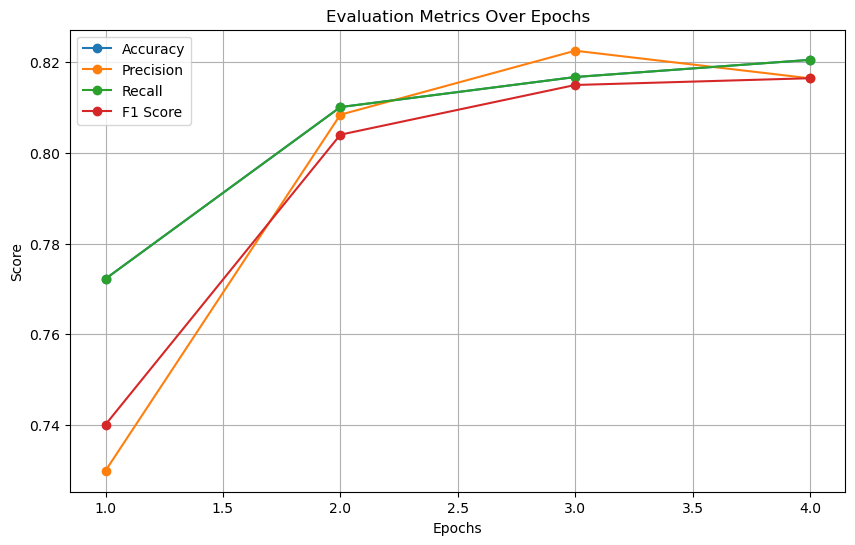

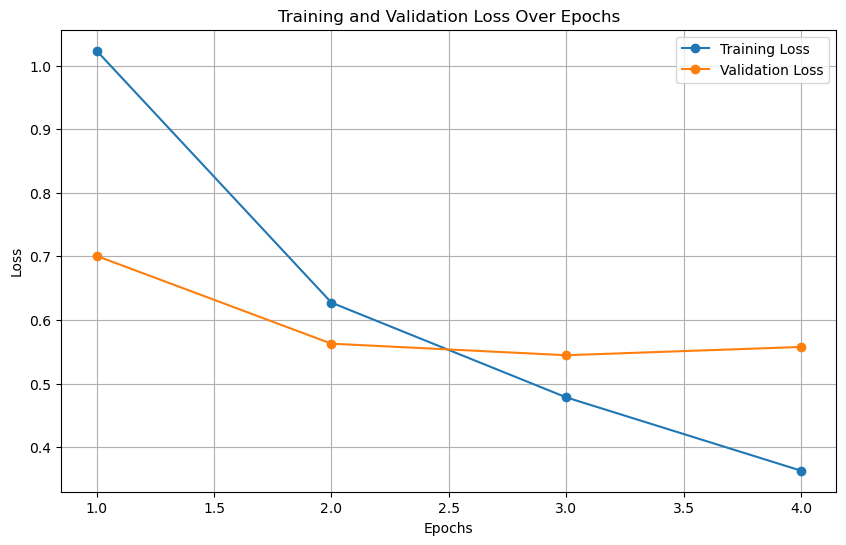

In [9]:
# Retrieve training history
training_history = trainer.state.log_history

# Extract evaluation metrics and losses after each epoch
epochs = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
training_losses = []
eval_losses = []

for log in training_history:
    if 'eval_accuracy' in log:  # Log evaluation metrics
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'])
        precisions.append(log['eval_precision'])
        recalls.append(log['eval_recall'])
        f1_scores.append(log['eval_f1'])
    if 'loss' in log:  # Log training loss
        training_losses.append(log['loss'])
    if 'eval_loss' in log:  # Log evaluation loss
        eval_losses.append(log['eval_loss'])

# Plotting the evaluation metrics
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.plot(epochs, precisions, label='Precision', marker='o')
plt.plot(epochs, recalls, label='Recall', marker='o')
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')

plt.title('Evaluation Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()